# PCA/SVD

In [55]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns

sys.path.append(os.path.join(os.path.abspath(''), '..'))

import constants

In [2]:
train = pd.read_csv(constants.TRAIN)
test = pd.read_csv(constants.TEST)

In [3]:
train

,Unnamed: 0,idx,mean,count,vert_symmetry,hor_symmetry,vert_mass_center,hor_mass_center,vert_viola,hor_viola,all_viola,label
0,0,12628,26.538265,122,10.081633,-18.117347,14.299144,14.299385,-32.581633,-42.862245,19.836735,7
1,1,37730,40.753827,155,-2.125000,-11.864796,13.984069,14.207067,-23.267857,-77.915816,0.829082,3
2,2,39991,41.187500,176,0.323980,-4.267857,14.086804,13.838004,-35.079082,-76.956633,-24.625000,8
3,3,8525,38.184949,155,-2.043367,-2.477041,14.146140,13.564352,-48.140306,-76.369898,-13.706633,9
4,4,8279,48.011480,204,-6.772959,-21.385204,13.838341,14.332457,-21.022959,-74.385204,-24.446429,3
...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,24023,49.288265,179,-12.688776,1.612245,13.566016,13.769448,-68.637755,-88.158163,2.275510,6
996,996,25697,15.947704,60,-0.640306,-19.854592,13.589698,14.413421,-14.966837,-31.895408,-10.094388,1
997,997,34049,35.149235,164,-10.558673,-9.573980,13.835577,14.277933,-48.966837,-67.589286,-20.778061,6
998,998,43215,48.392857,203,-0.750000,-10.158163,14.135240,14.335635,-50.530612,-78.086735,-36.336735,8


In [69]:
features = ['mean', 'count', 'vert_symmetry']

In [70]:
X_train = np.array([train[feature].values for feature in features]).T
X_test = np.array([test[feature].values for feature in features]).T

## Standardize

In [71]:
means = np.mean(X_train, axis=0, keepdims=True)
stds = np.std(X_train, axis=0, keepdims=True)
X_train_norm = (X_train - means) / stds

print('data scatter:', np.sum(X_train ** 2))
print('data scatter after centering: ', np.sum((X_train - means) ** 2))
print('data scatter after standardize: ', np.sum(X_train_norm ** 2))

data scatter: 25337027.391464494
data scatter after centering:  1998165.1463920956
data scatter after standardize:  2999.9999999999995


## SVD

In [74]:
pca = PCA()
transformed_array = pca.fit_transform(X_train_norm)
transformed = pd.DataFrame(transformed_array, columns=['PC' + str(i) for i in range(1, len(features) + 1)])

In [75]:
transformed.head()

,PC1,PC2,PC3
0,-1.317348,1.511233,0.042066
1,0.479915,0.407563,0.375165
2,0.757433,0.808916,0.052019
3,0.324062,0.374046,0.216130
4,1.857682,0.182502,0.009792


In [76]:
print('pca components: ', pca.components_)

pca components:  [[ 0.68032123  0.68058897 -0.27195897]
 [ 0.19338644  0.19122157  0.96230764]
 [ 0.70694038 -0.7072715  -0.00152458]]


In [77]:
scatter = np.sum(X_train_norm ** 2)
for col_name in transformed:
    col_scatter = np.sum(transformed[col_name] ** 2)
    scatter_percent = 100 * col_scatter / scatter
    print(col_name, 'contributes {0:.3f}, or {1:.2f}%, to the data scatter'.format(col_scatter, scatter_percent))

PC1 contributes 2046.691, or 68.22%, to the data scatter
PC2 contributes 916.404, or 30.55%, to the data scatter
PC3 contributes 36.905, or 1.23%, to the data scatter


## Hidden ranking factor

In [78]:
def rescale(df, low=0, high=100):
    return (df - df.min()) / (df.max() - df.min()) * (high - low) + low

rescaled_X = rescale(X_train_norm, 0, 100)
U, s, V = np.linalg.svd(rescaled_X)
contribution = 100 * s[0] ** 2 / np.sum(rescaled_X ** 2)

In [79]:
print('First component:', V[0])
print('Its contribution to the data scatter: {0:.3f}%'.format(contribution))

First component: [-0.58275984 -0.58273376 -0.56640298]
Its contribution to the data scatter: 96.349%


## Visualization

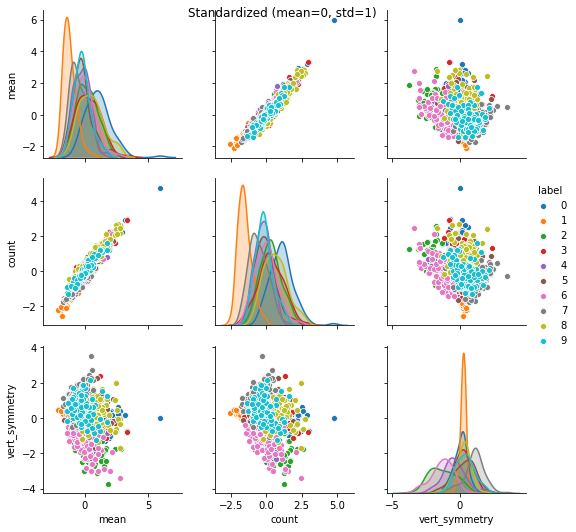

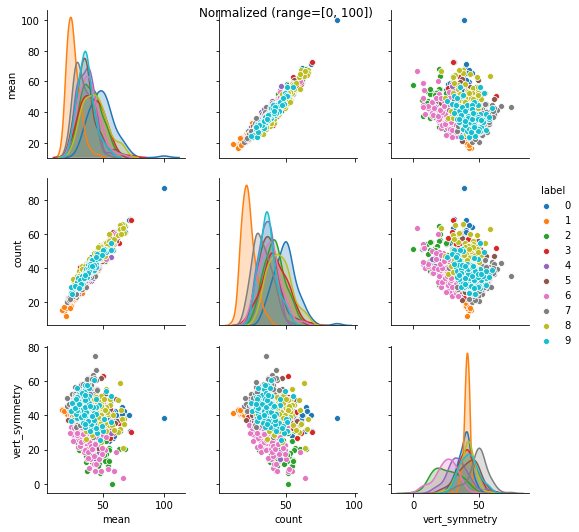

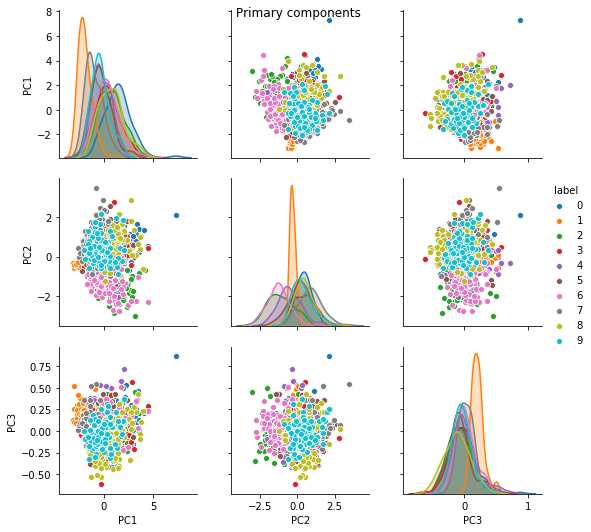

In [99]:
def pairplot(df, title):
    plot = sns.pairplot(df, vars=df.columns[:-1], hue='label')
    plot.fig.suptitle(title)

df_standart = pd.DataFrame(X_train_norm, columns=features) 
df_rescale = pd.DataFrame(rescaled_X, columns=features)
df_transform = pd.DataFrame(transformed_array, columns=['PC' + str(i) for i in range(1, len(features) + 1)])

for df in (df_standart, df_rescale, df_transform):
    df['label'] = train['label']

pairplot(df_standart, 'Standardized (mean=0, std=1)')
pairplot(df_rescale, 'Normalized (range=[0, 100])')
pairplot(df_transform, 'Primary components')

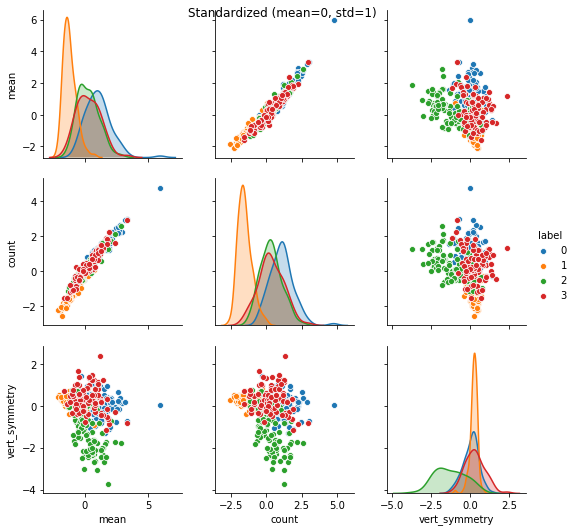

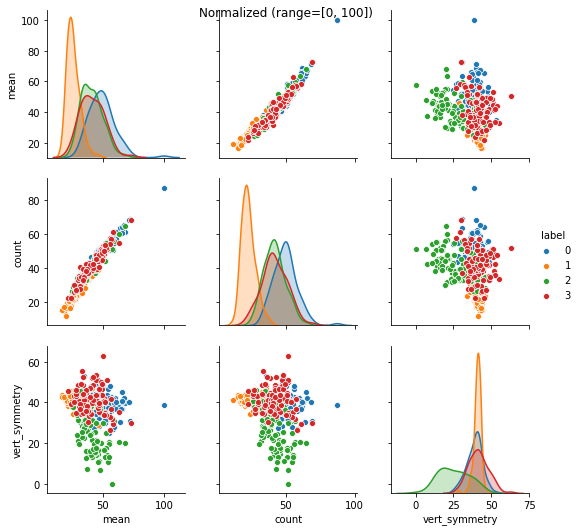

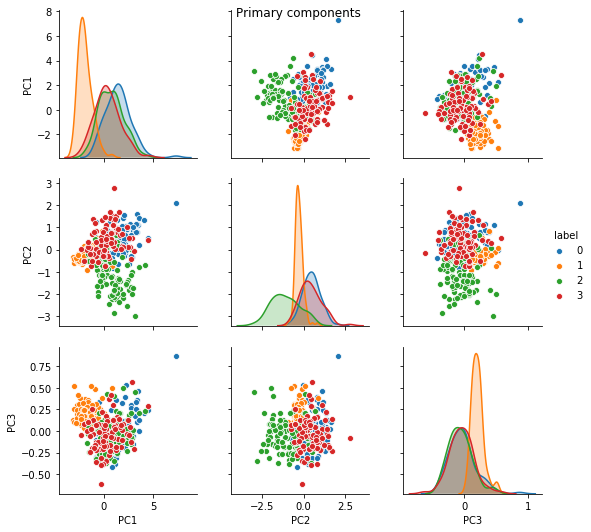

In [100]:
indexes = train['label'].values <= 3
df_standart, df_rescale, df_transform = [df[indexes] for df in (df_standart, df_rescale, df_transform)]

pairplot(df_standart, 'Standardized (mean=0, std=1)')
pairplot(df_rescale, 'Normalized (range=[0, 100])')
pairplot(df_transform, 'Primary components')